<a href="https://colab.research.google.com/github/infeimkr/codeit_ai4/blob/main/06_3%ED%8C%80_%EC%9E%84%EC%9D%B8%EC%B2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [31]:
!pip install torchinfo

import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import cv2
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset, ConcatDataset, WeightedRandomSampler
from torchvision.transforms import v2
import torchvision.models as models
from torch.optim.lr_scheduler import LambdaLR
from PIL import Image, ImageEnhance, ImageFilter
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import math
from tqdm import tqdm  # 진행 상황을 표시하기 위한 라이브러리
from collections import Counter
from torchinfo import summary
import time
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from IPython.display import display
import pandas as pd


# 0. 미션 설명
## 미션 소개
이번 미션에서는 흉부 X-Ray 사진을 바탕으로 폐렴 환자를 구분하는 작업을 수행합니다. 이번 미션의 목표는 X-Ray 사진을 입력으로 받아 폐렴 여부를 구분하는 분류(Classification) 모델을 만드는 것입니다. 아래 데이터셋을 활용하여 다양한 이미지 전처리 및 증강 기법과 Transfer Learning과 Fine-Tuning 기법을 실험해보고, 모델의 성능을 평가해 보세요.

## 데이터 소개
- 데이터 링크(Chest X-Ray Images (Pneumonia))
- train: 훈련 데이터
- test: 테스트 데이터
- val: 검증 데이터

# 1. 데이터 불러오기 및 검토

In [3]:
if 'COLAB_RELEASE_TAG' in os.environ:
    check_google_colab = True
    print("온라인 Colab 환경(Google 서버)")
else:
    check_google_colab = False
    print("로컬 런타임 환경")

온라인 Colab 환경(Google 서버)


In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    check_google_colab = True
    sub_path = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션6DATA"
    print("Google Colab 환경입니다.")
except ModuleNotFoundError:
    check_google_colab = False
    sub_path = "C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션6DATA"
    print("Local 환경입니다.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Colab 환경입니다.


In [5]:
# 폴더 경로 설정
if check_google_colab:
    train_dir = sub_path+"/train"
    val_dir = sub_path+"/val"
    test_dir = sub_path+"/test"
else:
    train_dir = sub_path+"/train"
    val_dir = sub_path+"/val"
    test_dir = sub_path+"/test"

print(train_dir)

/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션6DATA/train


 - 각 폴더별로 이미지 갯수와 최대 최소 사이즈, 채널 수를 확인합니다.

In [6]:
def summarize_image_sizes(root_folder):
    summary = {}

    for label_folder in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, label_folder)
        if not os.path.isdir(folder_path):
            continue

        img_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        if not img_files:
            continue

        heights, widths, ratios, channels = [], [], [], []
        for f in img_files:
            img_path = os.path.join(folder_path, f)
            img_data = np.fromfile(img_path, dtype=np.uint8)
            img = cv2.imdecode(img_data, cv2.IMREAD_COLOR)
            if img is None:
                continue

            h, w = img.shape[:2]
            heights.append(h)
            widths.append(w)
            ratios.append(w / h)
            if len(img.shape) == 2:   # 흑백
                channels.append(1)
            else:                     # 컬러 또는 알파 포함
                channels.append(img.shape[2])

        if not heights or not widths:
            continue

        summary[label_folder] = {
            "num_images": len(heights),
            "height_min": int(np.min(heights)),
            "height_max": int(np.max(heights)),
            "ratio_mean": round(float(np.mean(ratios)),2),
            "ratio_std": round(float(np.std(ratios)),2),
            "width_min": int(np.min(widths)),
            "width_max": int(np.max(widths)),
            "channels_set": list(set(channels)),
        }

    return summary

train_stats = summarize_image_sizes(train_dir)
val_stats   = summarize_image_sizes(val_dir)
test_stats  = summarize_image_sizes(test_dir)

In [7]:
print("Train_img_summary---------")
for folder in sorted(train_stats.keys()):
    info = train_stats[folder]
    print(f"{folder}: {info}")

print("\nval_img_summary--------")
for folder in sorted(val_stats.keys()):
    info = val_stats[folder]
    print(f"{folder}: {info}")

print("\ntest_img_summary---------")
for folder in sorted(test_stats.keys()):
    info = test_stats[folder]
    print(f"{folder}: {info}")

Train_img_summary---------
NORMAL: {'num_images': 1341, 'height_min': 672, 'height_max': 2663, 'ratio_mean': 1.23, 'ratio_std': 0.13, 'width_min': 912, 'width_max': 2916, 'channels_set': [3]}
PNEUMONIA: {'num_images': 3875, 'height_min': 127, 'height_max': 2304, 'ratio_mean': 1.51, 'ratio_std': 0.25, 'width_min': 384, 'width_max': 2772, 'channels_set': [3]}

val_img_summary--------
NORMAL: {'num_images': 8, 'height_min': 928, 'height_max': 1416, 'ratio_mean': 1.24, 'ratio_std': 0.08, 'width_min': 1240, 'width_max': 1776, 'channels_set': [3]}
PNEUMONIA: {'num_images': 8, 'height_min': 592, 'height_max': 1128, 'ratio_mean': 1.51, 'ratio_std': 0.13, 'width_min': 968, 'width_max': 1664, 'channels_set': [3]}

test_img_summary---------
NORMAL: {'num_images': 234, 'height_min': 496, 'height_max': 2713, 'ratio_mean': 1.37, 'ratio_std': 0.21, 'width_min': 984, 'width_max': 2752, 'channels_set': [3]}
PNEUMONIA: {'num_images': 390, 'height_min': 344, 'height_max': 1456, 'ratio_mean': 1.53, 'ratio

### 전처리 계획
1. val가 16장 밖에 안되서, train 에서 일부 가져와서 적용 (8:2)
2. 학습 데이터 불균형 Train_N:Train_P = 1341:3875 -> WeightedRandomSampler 적용
3. 들쭉날쭉한 사이즈에 맞춰 256으로 스케일링 후, train은 랜덤 크롭 224, val/test는 센터 크롭 224 적용


#### 전처리 수치 선언

In [8]:
RAW_RESIZE = 256
CROP_SIZE = 224
EXTRA_VAL_RATE = 0.2
RANDOM_ROTATION = 10

# 2. 데이터 전처리

In [9]:
# 첫 로드 리사이즈
base_transform = transforms.Resize((RAW_RESIZE))

# raw 데이터셋 - ImageFolder 사용
train_dataset_raw = datasets.ImageFolder(train_dir, transform=base_transform)
val_dataset_raw   = datasets.ImageFolder(val_dir, transform=base_transform)
test_dataset_raw  = datasets.ImageFolder(test_dir, transform=base_transform)

# 데이터셋 카운트
train_targets = [label for _, label in train_dataset_raw.samples]
train_counts = Counter(train_targets)

val_targets = [label for _, label in val_dataset_raw.samples]
val_counts = Counter(val_targets)

test_targets = [label for _, label in test_dataset_raw.samples]
test_counts = Counter(test_targets)

print("train raw:", {k: train_counts[k] for k in sorted(train_counts.keys())})
print("val raw:", {k: val_counts[k] for k in sorted(val_counts.keys())})
print("test raw:", {k: test_counts[k] for k in sorted(test_counts.keys())})

train raw: {0: 1341, 1: 3875}
val raw: {0: 8, 1: 8}
test raw: {0: 234, 1: 390}


- train raw 데이터에서 N:P = 1:1 비율로 var로 옮기기

In [10]:
# 1:1 비율로 train 데이터셋에서 extra var 가져오기
train_targets_arr = np.array([label for _, label in train_dataset_raw.samples])

normal_idx = np.where(train_targets_arr == 0)[0]
pneumonia_idx = np.where(train_targets_arr == 1)[0]

extra_val_count = int(len(normal_idx) * EXTRA_VAL_RATE)

extra_val_normal_idx = np.random.choice(normal_idx, extra_val_count, replace=False)
extra_val_pneumonia_idx = np.random.choice(pneumonia_idx, extra_val_count, replace=False)

extra_val_idx = np.concatenate([extra_val_normal_idx, extra_val_pneumonia_idx])
np.random.shuffle(extra_val_idx)

# train_idx = extra val 외 나머지 인덱스
train_idx = np.array([i for i in range(len(train_targets_arr)) if i not in extra_val_idx])

train_dataset = Subset(train_dataset_raw, train_idx)
extra_val_dataset = Subset(train_dataset_raw, extra_val_idx)

# val 데이터셋
val_dataset = ConcatDataset([val_dataset_raw, extra_val_dataset])

# 데이터셋 카운트
train_subset_labels = [train_dataset_raw.targets[i] for i in train_dataset.indices]
train_counts = Counter(train_subset_labels)

val_subset_labels = []
val_subset_labels += val_dataset_raw.targets
val_subset_labels += [train_dataset_raw.targets[i] for i in extra_val_dataset.indices]
val_counts = Counter(val_subset_labels)

print("train:", {k: train_counts[k] for k in sorted(train_counts.keys())})
print("val:",   {k: val_counts[k] for k in sorted(val_counts.keys())})
print("test:",  {k: test_counts[k] for k in sorted(test_counts.keys())})

train: {0: 1073, 1: 3607}
val: {0: 276, 1: 276}
test: {0: 234, 1: 390}


In [11]:
# 환경에 따라 배치 사이즈 변경
if check_google_colab:
    batch_size = 64
else:
    batch_size = 32

In [ ]:
# 트랜스폼
train_transform = transforms.Compose([
#    transforms.RandomResizedCrop(CROP_SIZE, scale=(0.8, 1.0), ratio=(1.0, 1.6)),  # transform 처리 시 병목으로 예상되서 일시 주석처리
    transforms.CenterCrop(CROP_SIZE),                                              # transform 처리 시 병목으로 예상되서 일시 적용
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(RANDOM_ROTATION),
#    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 10% 시프트       # transform 처리 시 병목으로 예상되서 일시 주석처리
    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.5], std=[0.5]),                                  # resNet 학습 데이터에 맞춰서 ImageNet 정규화로.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.5], std=[0.5]),                                  # resNet 학습 데이터에 맞춰서 ImageNet 정규화로.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    def __len__(self):
        return len(self.subset)

train_dataset_final = TransformDataset(train_dataset, transform=train_transform)
val_dataset_final = TransformDataset(val_dataset, transform=val_test_transform)
test_dataset_final = TransformDataset(test_dataset_raw, transform=val_test_transform)

targets = [label for _, label in train_dataset_final]
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader
train_loader = DataLoader(train_dataset_final, batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset_final, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_final, batch_size, shuffle=False)

print("Train:", len(train_dataset_final))
print("Val:", len(val_dataset_final))
print("Test:", len(test_dataset_final))

In [13]:
# 테스트 1 에폭, train_loader 라벨 밸런스 확인용 //너무 오래걸려서 확인 후 주석처리 필요

def count_sampled_labels(dataloader):
    counts = Counter()
    for _, labels in tqdm(dataloader, leave=True, desc='Sampled'):
        counts.update(labels.tolist())
    return counts

sampled_train_counts = count_sampled_labels(train_loader)

print("\nSampled train labels:", sampled_train_counts)


'\ndef count_sampled_labels(dataloader):\n    counts = Counter()\n    for _, labels in tqdm(dataloader, leave=True, desc=\'Sampled\'):\n        counts.update(labels.tolist())\n    return counts\n\nsampled_train_counts = count_sampled_labels(train_loader)\n\nprint("\nSampled train labels:", sampled_train_counts)\n'

- train_dataset_final 내에 label 별로 대략 1:1 비율 확인

# 3. 모델링


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 1) 모델 이름 = model_simpleCNN
- SimpleCNN
    -> 이진 분류 from Scratch (확인용)

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):  # 이진 분류 → 2
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * (CROP_SIZE//4) * (CROP_SIZE//4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### 2) Transfer Learning (resNet18)
    -> resNet18 기반

#### 2-1) 모델 이름 = model_resNet18_feature_extraction
- resNet 18 + IMAGENET1K_V1 - Feature Extractor -> Frozen

In [16]:
def get_resnet_feature_extraction(num_classes=2):
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False   # freeze 모든 conv layer

    model.fc = nn.Linear(model.fc.in_features, num_classes)  # classifier 교체
    return model

#### 2-2) 모델 이름 = model_resNet18_Partial
- resNet 18 + IMAGENET1K_V1 - Partial -> unfreeze layer4

In [17]:
def get_resnet_partial(num_classes=2, unfreeze_from_layer=4):
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False   # freeze 모든 conv layer

    for param in model.layer4.parameters(): # unfreeze layer 4
        param.requires_grad = True

    model.fc = nn.Linear(model.fc.in_features, num_classes)  # classifier 교체
    return model

#### 2-3) 모델 이름 = model_resNet18_finetune
- resNet 18 + IMAGENET1K_V1 - Fine-tuning

In [18]:
def get_resnet_finetune(num_classes=2):
    model = models.resnet18(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = True   # unfreeze 모든 conv layer

    model.fc = nn.Linear(model.fc.in_features, num_classes)  # classifier 교체
    return model

### 3) 모델 선언 및 학습 진행

In [19]:
# 학습 시각화
def plot_loss_acc(train_losses, train_accs, val_losses, val_accs, model_title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12,5))
    plt.suptitle(model_title)
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.show()

In [ ]:
# 학습 & 검증 루프
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, model_title=None):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    total_learning_time = 0
    model = model.to(device)
    for epoch in range(epochs):
        start_time = time.time()  # epoch 시작 시간
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, leave=False, desc='Train'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation
        model.eval()
        running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, leave=False, desc='Val'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = running_loss / val_total
        val_acc = val_correct / val_total * 100
        val_losses.append(epoch_val_loss)
        val_accs.append(val_acc)

        if epoch % 5 == 0 or (epoch+1) == EPOCHS:
            end_time = time.time()  # epoch 끝 시간
            epoch_time = end_time - start_time
            total_learning_time += epoch_time

            print(f"\rEpoch {epoch+1}/{epochs} | "
                f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | "
                f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
                f"Processing Time: {epoch_time:.1f}s", end="\n")

    elapsed = str(datetime.timedelta(seconds=int(total_learning_time)))
    print(f"Total Time: {elapsed}")
    plot_loss_acc(train_losses, train_accs, val_losses, val_accs, model_title)


In [21]:
# 환경에 따라 에폭 사이즈 변경
if check_google_colab:
    EPOCHS = 20
else:
    EPOCHS = 10

criterion = nn.CrossEntropyLoss()
num_classes = 2 # 이진분류

=====SimpleCNN=====


Epoch 1/40 | Train Loss: 0.9732 | Train Acc: 67.61% | Val Loss: 0.2154 | Val Acc: 93.30% | Time: 124.4s


Epoch 6/40 | Train Loss: 0.2227 | Train Acc: 91.94% | Val Loss: 0.3772 | Val Acc: 84.42% | Time: 121.6s


Epoch 11/40 | Train Loss: 0.1838 | Train Acc: 92.93% | Val Loss: 0.1475 | Val Acc: 94.20% | Time: 121.3s


Epoch 16/40 | Train Loss: 0.1590 | Train Acc: 94.27% | Val Loss: 0.0933 | Val Acc: 96.01% | Time: 122.9s


Epoch 21/40 | Train Loss: 0.1654 | Train Acc: 93.97% | Val Loss: 0.1197 | Val Acc: 95.29% | Time: 122.2s


Epoch 26/40 | Train Loss: 0.1474 | Train Acc: 94.64% | Val Loss: 0.1418 | Val Acc: 93.30% | Time: 122.2s


Epoch 31/40 | Train Loss: 0.1354 | Train Acc: 94.96% | Val Loss: 0.1066 | Val Acc: 96.01% | Time: 121.4s


Epoch 36/40 | Train Loss: 0.1570 | Train Acc: 94.40% | Val Loss: 0.1268 | Val Acc: 95.29% | Time: 123.1s


Epoch 40/40 | Train Loss: 0.1372 | Train Acc: 94.49% | Val Loss: 0.1091 | Val Acc: 95.83% | Time: 125.9s
Total Time: 1:22:18


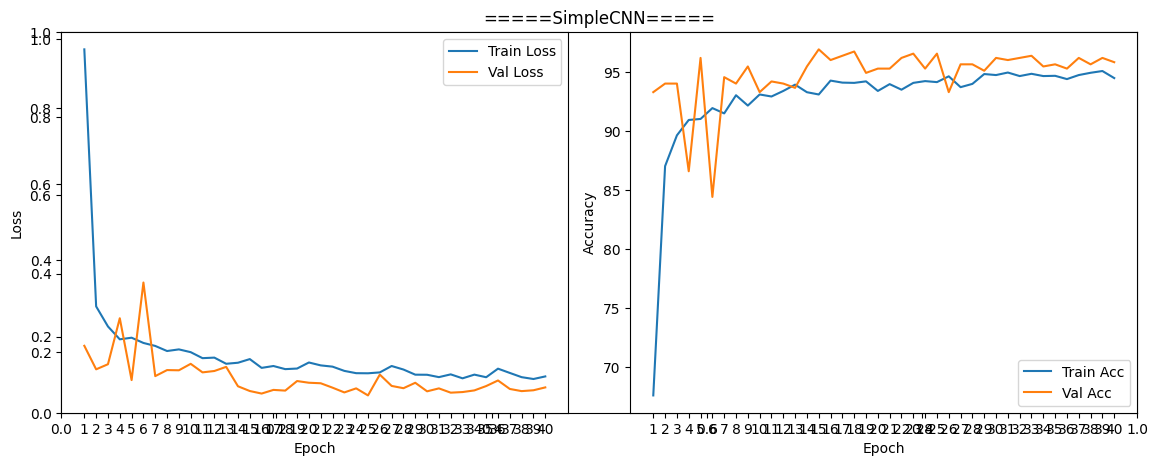

In [22]:
# SimpleCNN 학습
model_simpleCNN = SimpleCNN(num_classes)
optimizer = torch.optim.AdamW(model_simpleCNN.parameters(), lr=0.001)
model_title = "=====SimpleCNN====="
print(model_title)
train_model(model_simpleCNN, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS, model_title=model_title)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


=====resNet18_Frozen=====


Epoch 1/40 | Train Loss: 0.5183 | Train Acc: 76.18% | Val Loss: 0.4425 | Val Acc: 80.25% | Time: 146.7s


Epoch 6/40 | Train Loss: 0.2286 | Train Acc: 91.09% | Val Loss: 0.2795 | Val Acc: 88.22% | Time: 124.1s


Epoch 11/40 | Train Loss: 0.1973 | Train Acc: 92.56% | Val Loss: 0.1991 | Val Acc: 92.21% | Time: 125.5s


Epoch 16/40 | Train Loss: 0.1930 | Train Acc: 92.56% | Val Loss: 0.1505 | Val Acc: 94.38% | Time: 120.8s


Epoch 21/40 | Train Loss: 0.1719 | Train Acc: 93.16% | Val Loss: 0.1501 | Val Acc: 94.20% | Time: 120.1s


Epoch 26/40 | Train Loss: 0.1709 | Train Acc: 93.55% | Val Loss: 0.1504 | Val Acc: 94.02% | Time: 120.0s


Epoch 31/40 | Train Loss: 0.1712 | Train Acc: 93.23% | Val Loss: 0.1475 | Val Acc: 94.57% | Time: 120.6s


Epoch 36/40 | Train Loss: 0.1650 | Train Acc: 93.53% | Val Loss: 0.1371 | Val Acc: 94.57% | Time: 119.8s


Epoch 40/40 | Train Loss: 0.1592 | Train Acc: 93.91% | Val Loss: 0.1450 | Val Acc: 94.38% | Time: 120.1s
Total Time: 1:21:25


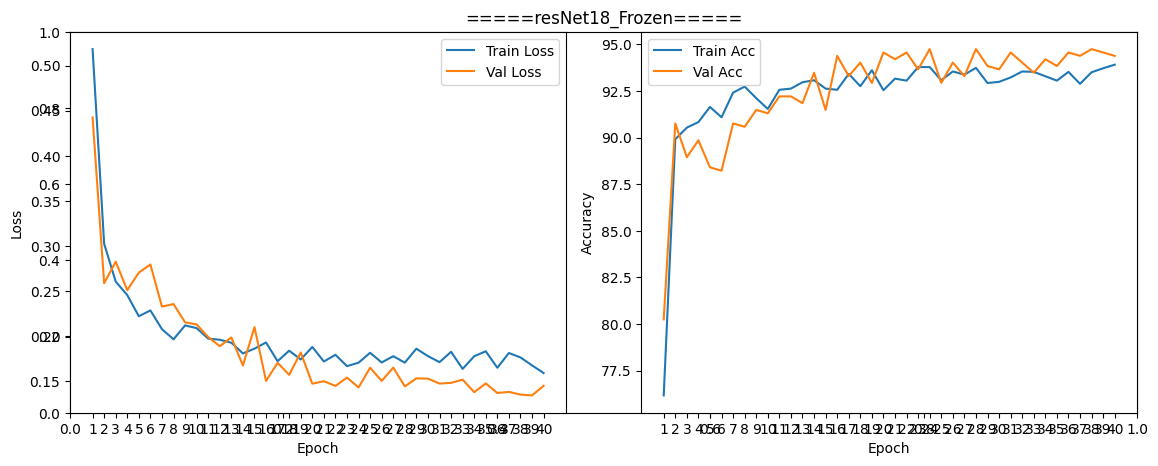

In [23]:
# resNet18_Frozen
model_resNet18_feature_extraction = get_resnet_feature_extraction(num_classes)
optimizer = torch.optim.AdamW(model_resNet18_feature_extraction .parameters(), lr=0.001)
model_title = "=====resNet18_Frozen====="
print(model_title)
train_model(model_resNet18_feature_extraction, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS, model_title=model_title)

=====resNet18_Partial=====


Epoch 1/40 | Train Loss: 0.1939 | Train Acc: 92.29% | Val Loss: 0.6265 | Val Acc: 78.08% | Time: 122.9s


Epoch 6/40 | Train Loss: 0.0582 | Train Acc: 97.74% | Val Loss: 0.1925 | Val Acc: 93.12% | Time: 128.4s


Epoch 11/40 | Train Loss: 0.0475 | Train Acc: 98.42% | Val Loss: 0.1658 | Val Acc: 94.93% | Time: 122.6s


Epoch 16/40 | Train Loss: 0.0293 | Train Acc: 99.00% | Val Loss: 0.1677 | Val Acc: 94.75% | Time: 123.1s


Epoch 21/40 | Train Loss: 0.0280 | Train Acc: 99.02% | Val Loss: 0.1060 | Val Acc: 97.10% | Time: 119.5s


Epoch 26/40 | Train Loss: 0.0232 | Train Acc: 99.06% | Val Loss: 0.1121 | Val Acc: 96.56% | Time: 123.0s


Epoch 31/40 | Train Loss: 0.0148 | Train Acc: 99.51% | Val Loss: 0.2024 | Val Acc: 95.47% | Time: 124.3s


Epoch 36/40 | Train Loss: 0.0162 | Train Acc: 99.32% | Val Loss: 0.1330 | Val Acc: 95.83% | Time: 123.3s


Epoch 40/40 | Train Loss: 0.0164 | Train Acc: 99.42% | Val Loss: 0.1690 | Val Acc: 95.29% | Time: 123.3s
Total Time: 1:21:59


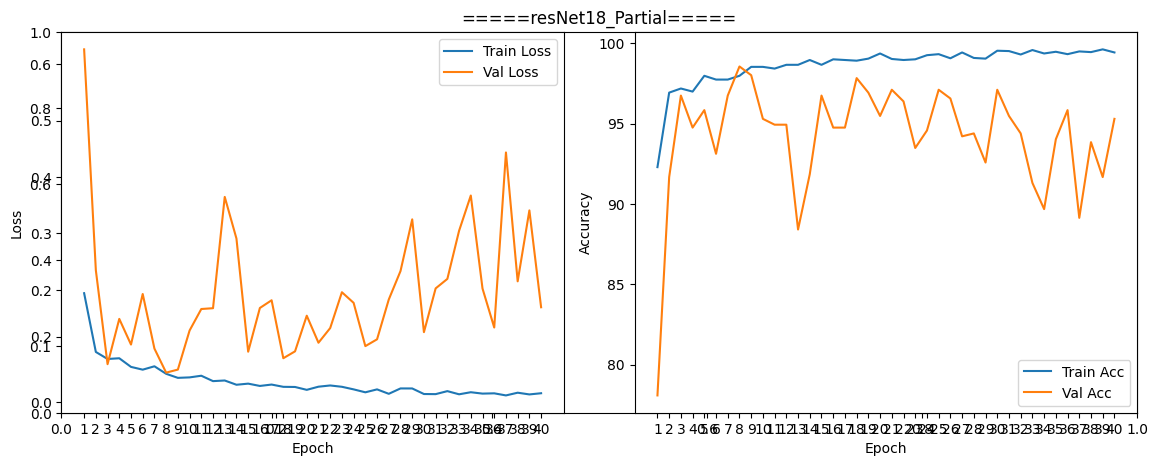

In [24]:
# resNet18_Partial
model_resNet18_Partial = get_resnet_partial(num_classes, unfreeze_from_layer=4)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model_resNet18_Partial.parameters()), lr=0.0001)
model_title = "=====resNet18_Partial====="
print(model_title)
train_model(model_resNet18_Partial, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS, model_title=model_title)

=====resNet18_finetune=====


Epoch 1/40 | Train Loss: 0.1791 | Train Acc: 92.29% | Val Loss: 0.7420 | Val Acc: 74.28% | Time: 128.1s


Epoch 6/40 | Train Loss: 0.0449 | Train Acc: 98.61% | Val Loss: 0.1976 | Val Acc: 93.30% | Time: 129.2s


Epoch 11/40 | Train Loss: 0.0215 | Train Acc: 99.15% | Val Loss: 0.1709 | Val Acc: 94.57% | Time: 127.8s


Epoch 16/40 | Train Loss: 0.0223 | Train Acc: 99.17% | Val Loss: 0.1187 | Val Acc: 96.74% | Time: 126.5s


Epoch 21/40 | Train Loss: 0.0125 | Train Acc: 99.59% | Val Loss: 0.1231 | Val Acc: 96.56% | Time: 126.9s


Epoch 26/40 | Train Loss: 0.0140 | Train Acc: 99.55% | Val Loss: 0.2798 | Val Acc: 92.21% | Time: 122.8s


Epoch 31/40 | Train Loss: 0.0107 | Train Acc: 99.57% | Val Loss: 0.2289 | Val Acc: 94.75% | Time: 124.9s


Epoch 36/40 | Train Loss: 0.0070 | Train Acc: 99.76% | Val Loss: 0.3633 | Val Acc: 90.58% | Time: 125.5s


Epoch 40/40 | Train Loss: 0.0052 | Train Acc: 99.87% | Val Loss: 0.3321 | Val Acc: 92.03% | Time: 125.3s
Total Time: 1:24:18


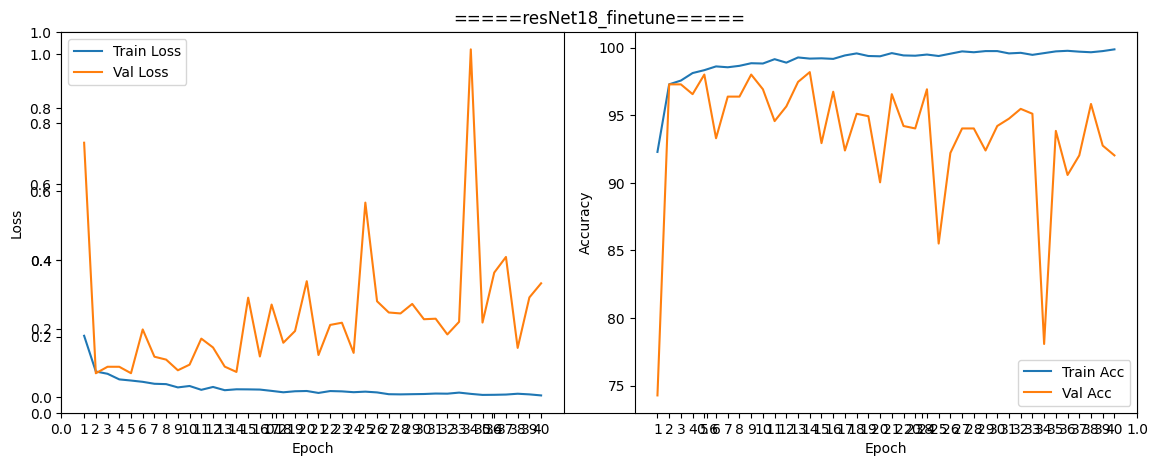

In [25]:
# resNet18_fine-tune
model_resNet18_finetune = get_resnet_finetune(num_classes)
optimizer = torch.optim.AdamW(model_resNet18_finetune .parameters(), lr=0.0001)
model_title = "=====resNet18_finetune====="
print(model_title)
train_model(model_resNet18_finetune, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS, model_title=model_title)

In [26]:
summary(model_resNet18_Partial, input_size=(batch_size, 3, CROP_SIZE, CROP_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 2]                  --
├─Conv2d: 1-1                            [128, 64, 112, 112]       (9,408)
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       (128)
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         (36,864)
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         (128)
│    │    └─ReLU: 3-6                    [128, 64, 56, 56] 

# 4. 평가 지표 확인


In [41]:
def evaluate_model(model, test_loader, criterion, model_name="Model"):
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # numpy array 변환
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 성능 지표 계산
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    print("\n", "="*80)
    print(f"📊 Classification Report for {model_name}")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

    print(f"✅ Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall: {rec:.4f}")
    print(f"✅ F1-score: {f1:.4f}", "\n")

    # 혼동행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, prec, rec, f1


📊 Classification Report for SimpleCNN
              precision    recall  f1-score   support

      Normal       0.94      0.45      0.61       234
   Pneumonia       0.75      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.72      0.73       624
weighted avg       0.82      0.78      0.76       624

✅ Test Loss: 1.0099
✅ Accuracy: 0.7821
✅ Precision: 0.7480
✅ Recall: 0.9821
✅ F1-score: 0.8492 



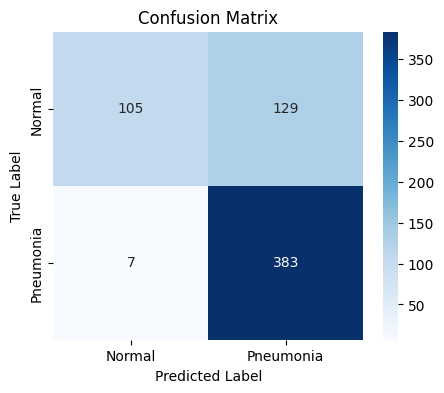


📊 Classification Report for ResNet18 (Feature Extraction)
              precision    recall  f1-score   support

      Normal       0.89      0.75      0.81       234
   Pneumonia       0.86      0.94      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.87      0.87      0.87       624

✅ Test Loss: 0.3301
✅ Accuracy: 0.8718
✅ Precision: 0.8638
✅ Recall: 0.9436
✅ F1-score: 0.9020 



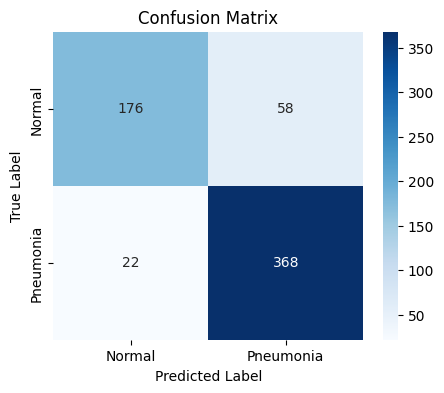


📊 Classification Report for ResNet18 (Partial)
              precision    recall  f1-score   support

      Normal       1.00      0.44      0.61       234
   Pneumonia       0.75      1.00      0.86       390

    accuracy                           0.79       624
   macro avg       0.87      0.72      0.73       624
weighted avg       0.84      0.79      0.76       624

✅ Test Loss: 1.6658
✅ Accuracy: 0.7901
✅ Precision: 0.7486
✅ Recall: 1.0000
✅ F1-score: 0.8562 



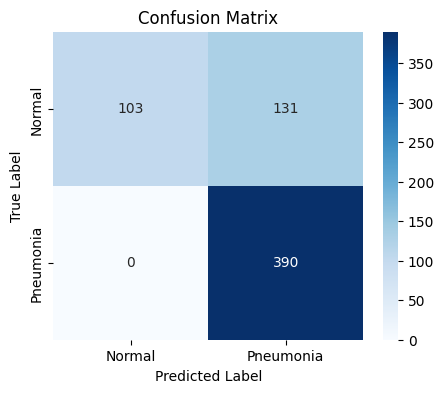


📊 Classification Report for ResNet18 (Fine-tuning)
              precision    recall  f1-score   support

      Normal       1.00      0.41      0.58       234
   Pneumonia       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.87      0.70      0.71       624
weighted avg       0.84      0.78      0.75       624

✅ Test Loss: 1.9480
✅ Accuracy: 0.7772
✅ Precision: 0.7372
✅ Recall: 1.0000
✅ F1-score: 0.8487 



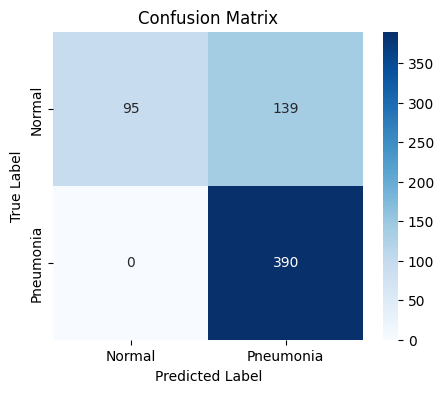


 =================================== Final Score ===================================


,Model,Accuracy,Precision,Recall,F1-score
0,SimpleCNN,78.21%,74.8%,98.21%,84.92%
1,ResNet18 (Feature Extraction),87.18%,86.38%,94.36%,90.2%
2,ResNet18 (Partial),79.01%,74.86%,100.0%,85.62%
3,ResNet18 (Fine-tuning),77.72%,73.72%,100.0%,84.87%


In [43]:
models_to_test = {
    "SimpleCNN": model_simpleCNN,
    "ResNet18 (Feature Extraction)": model_resNet18_feature_extraction,
    "ResNet18 (Partial)": model_resNet18_Partial,
    "ResNet18 (Fine-tuning)": model_resNet18_finetune,
}

results = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}

for model_name, model in models_to_test.items():
    acc, prec, rec, f1 = evaluate_model(model, test_loader, criterion, model_name=model_name)
    results["Model"].append(model_name)
    results["Accuracy"].append(f"{round(acc*100,2)}%")
    results["Precision"].append(f"{round(prec*100,2)}%")
    results["Recall"].append(f"{round(rec*100,2)}%")
    results["F1-score"].append(f"{round(f1*100,2)}%")

df_results = pd.DataFrame(results)

print("\n", "="*35, "Final Score", "="*35)
display(df_results)